In [ ]:
%pip install -r requirements.txt --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

sns.set_theme(rc={'figure.figsize':(10,8)})
sns.set_palette("bright")

Note: you may need to restart the kernel to use updated packages.


In [2]:
from pandas.core.frame import DataFrame


from sklearn.datasets import load_wine

df, y = load_wine(return_X_y=True, as_frame=True)
df: DataFrame = pd.DataFrame(df)
y = pd.Series(y.astype("category"))
# df = pd.read_csv("data.csv")
display(df.head())
print(df.dtypes)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object


In [3]:
# df = df.astype(
#     {
#         "Repetition": "category",
#         "Season": "category",
#     },
#     copy=False,
# )

num_cols = df.select_dtypes(np.number).columns
cat_cols = df.select_dtypes("category").columns

print("Numerical:")
display(df.describe(percentiles=[], include=np.number).round(2))
if not cat_cols.empty:
    print("Categorical/Ordered")
    display(df.describe(exclude=[np.number, 'datetime']))

Numerical:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00
50%,13.05,1.87,2.36,19.50,98.00,2.36,2.13,0.34,1.56,4.69,0.96,2.78,673.50
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler().fit(df[num_cols])

df_st_num = pd.DataFrame(scaler.transform(df[num_cols]), columns=num_cols)

if not cat_cols.empty:
    encoder = OneHotEncoder(sparse_output=False).fit(df[cat_cols])
    df_enc_cat = pd.DataFrame(encoder.transform(df[cat_cols]), columns=encoder.get_feature_names_out())
    df_processed = pd.concat([df_st_num, df_enc_cat], axis=1)
else:
    df_processed = df_st_num
# outliers_b = (df_processed["NGP"] > 4) | (df_processed["NGL"] > 2)
# df_processed = df_processed[~outliers_b]

# sns.pairplot(pd.concat([df_processed[num_cols], y], axis=1), hue="target");

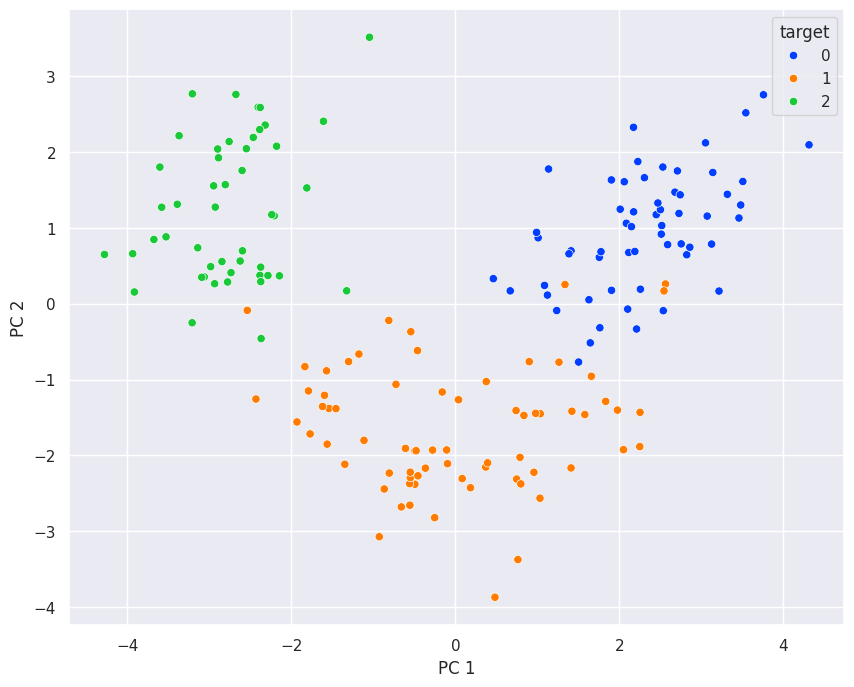

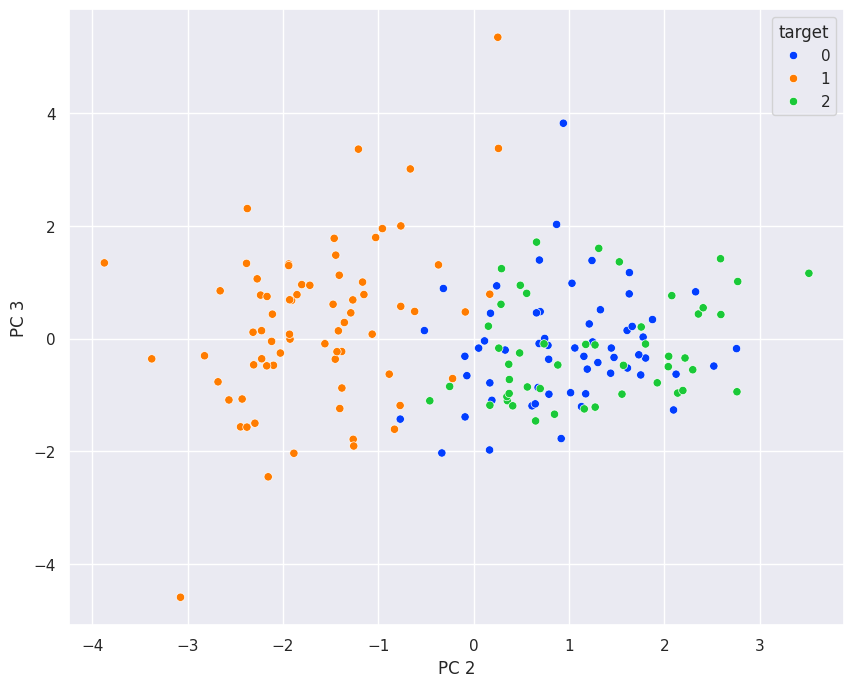

In [5]:
from sklearn.decomposition import PCA

df_pca = PCA(3).fit_transform(df_processed)

pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=y)
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")
plt.show()

pcaplot = sns.scatterplot(x=df_pca[:,1], y=df_pca[:, 2], hue=y)
pcaplot.set_xlabel("PC 2")
pcaplot.set_ylabel("PC 3")
plt.show()

# Meanshift

In [6]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(df_processed, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth)
ms.fit(df_processed)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 6


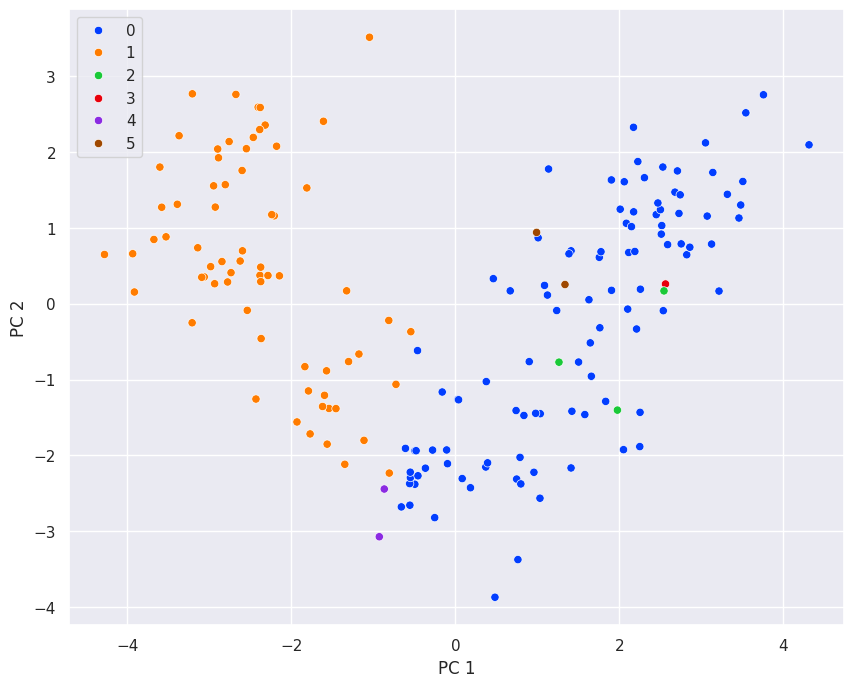

In [7]:
pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=labels, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

# EM-Алгоритм

In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 6),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

gmm = GridSearchCV(
    GaussianMixture(),
    param_grid=param_grid,
    scoring=gmm_bic_score,
    cv=df_processed.shape[0],
    n_jobs=-1
)
gmm.fit(df_processed)

,estimator,GaussianMixture()
,param_grid,"{'covariance_type': ['spherical', 'tied', ...], 'n_components': range(1, 6)}"
,scoring,<function gmm...x7f13999779c0>
,n_jobs,-1
,refit,True
,cv,178
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_components,3


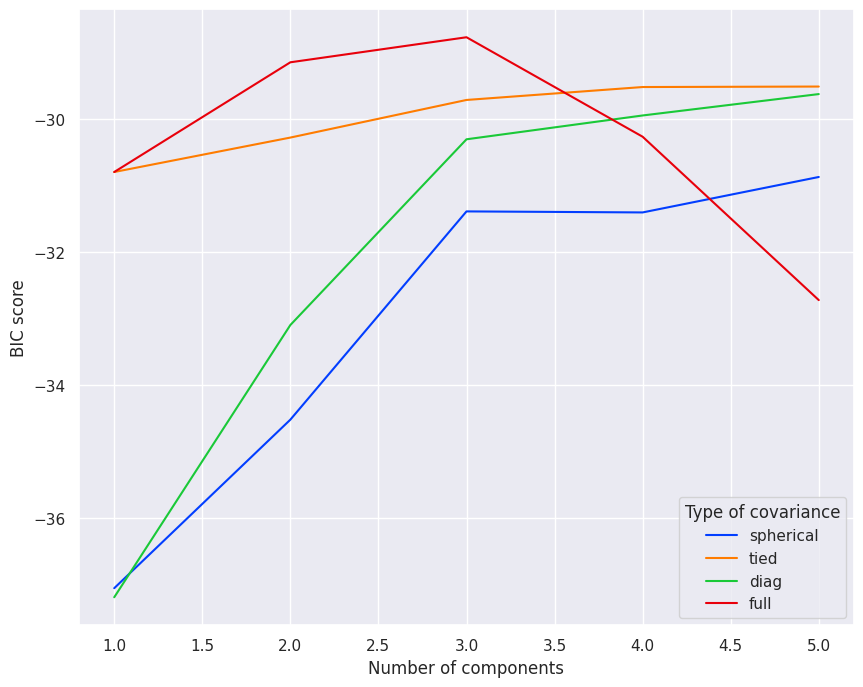

In [9]:
gmm_cv_df = pd.DataFrame(gmm.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]

gmm_cv_df = gmm_cv_df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)


sns.lineplot(
    gmm_cv_df,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
);

{'covariance_type': 'full', 'n_components': 3}


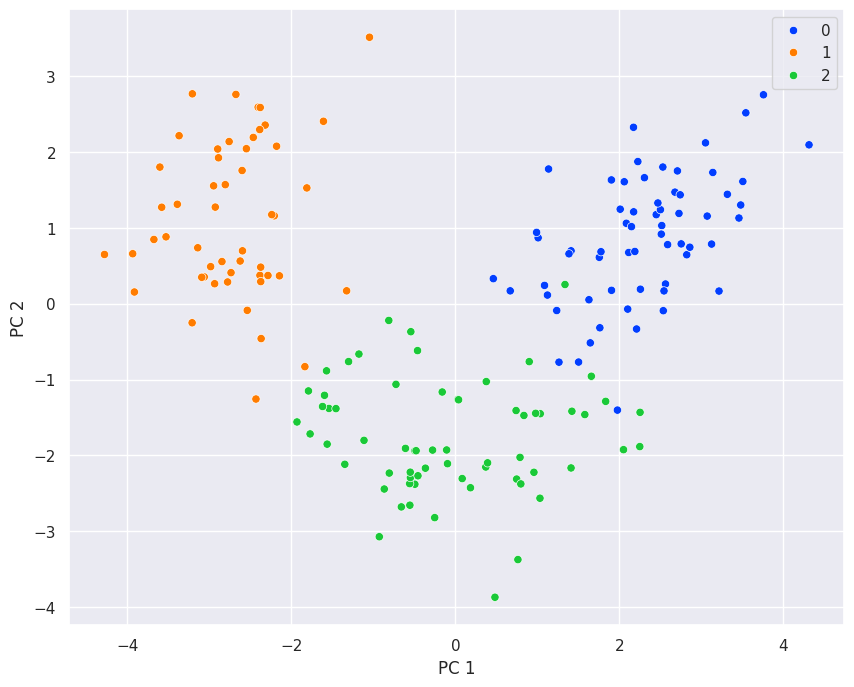

In [10]:
print(gmm.best_params_)
labels = gmm.best_estimator_.predict(df_processed)

pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=labels, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

# DBSCAN

In [28]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score, davies_bouldin_score


param_grid = {
    "eps": [x / 10 for x in range(5, 51, 5)],
    "min_samples": range(1, 10),
}

def ar_score(estimator, X, y):
    return adjusted_rand_score(y, estimator.fit_predict(X))

def db_score(estimator, X):
    return davies_bouldin_score(X, estimator.fit_predict(X))

dbs_ar = GridSearchCV(
    DBSCAN(),
    param_grid=param_grid,
    scoring=ar_score,
    cv=5,
    n_jobs=-1,
)

dbs_db = GridSearchCV(
    DBSCAN(),
    param_grid=param_grid,
    scoring=db_score,
    cv=5,
    n_jobs=-1,
)

dbs_ar.fit(df_processed, y)
dbs_db.fit(df_processed)

dbs = DBSCAN(eps=2.4, min_samples=3).fit(df_processed)

/home/nikita/Projects/Python/ML/SL_ML_learning/Statistical_and_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/nikita/Projects/Python/ML/SL_ML_learning/Statistical_and_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(labels_pred)
/home/nikita/Projects/Python/ML/SL_ML_learning/Statistical_and_Machine_Learning/.venv/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression p

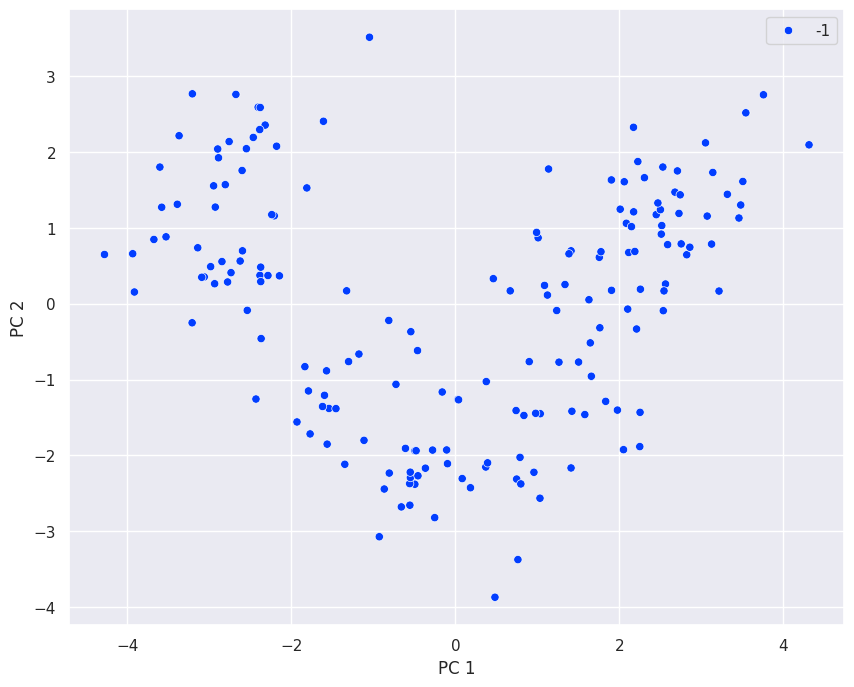

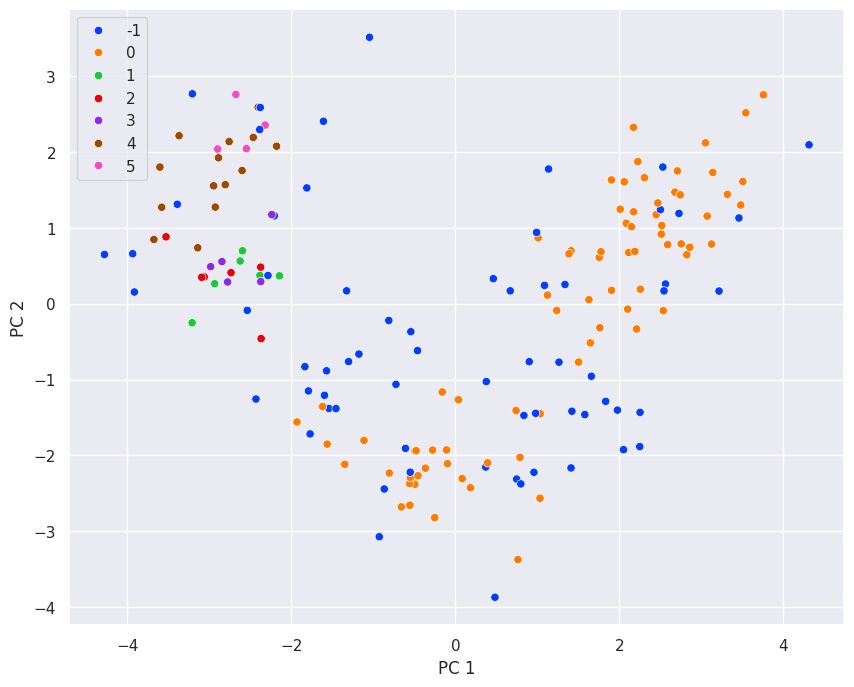

In [29]:
pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=dbs_ar.best_estimator_.labels_, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=dbs_db.best_estimator_.labels_, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

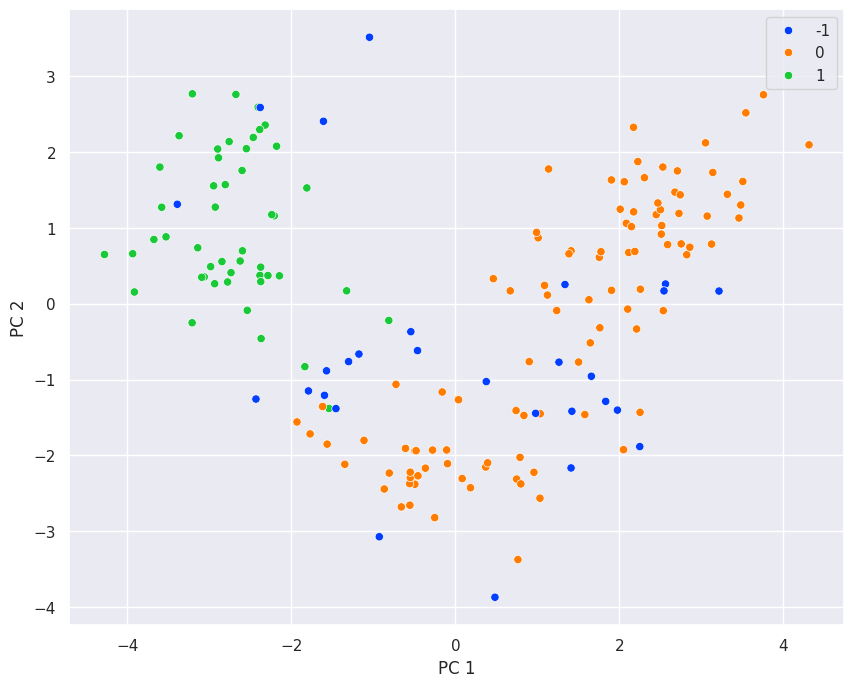

In [30]:
labels = dbs.labels_

pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=labels, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

# OPTICS

In [31]:
from sklearn.cluster import OPTICS

opt = OPTICS(min_samples=3, cluster_method="dbscan", eps=2.4, min_cluster_size=15).fit(df_processed)

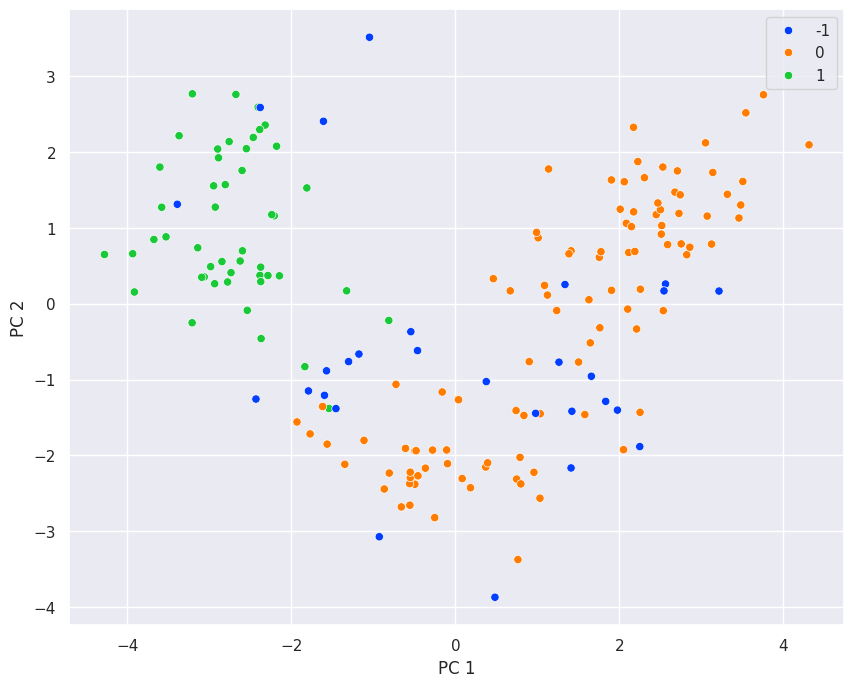

In [32]:
labels = opt.labels_

pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=labels, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

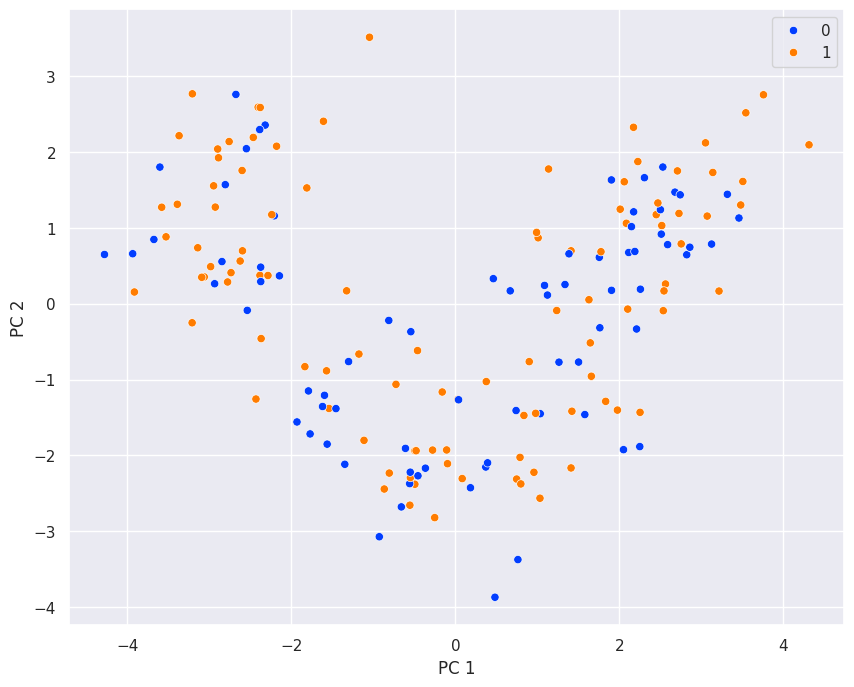

In [33]:
import waveCluster

labels = waveCluster.waveCluster(data=df_processed.values, scale=4, threshold=0.)
pcaplot = sns.scatterplot(x=df_pca[:,0], y=df_pca[:, 1], hue=labels, palette="bright")
pcaplot.set_xlabel("PC 1")
pcaplot.set_ylabel("PC 2")

plt.show()

In [146]:
from pyclustering.cluster.clique import clique, clique_visualizer

clique_instance = clique(data=df_pca[:, :2], amount_intervals=20, density_threshold=0)
clique_instance.process()
clusters = clique_instance.get_clusters()
noise = clique_instance.get_noise()
cells = clique_instance.get_cells() 
print("Amount of clusters:", len(clusters))

Amount of clusters: 16


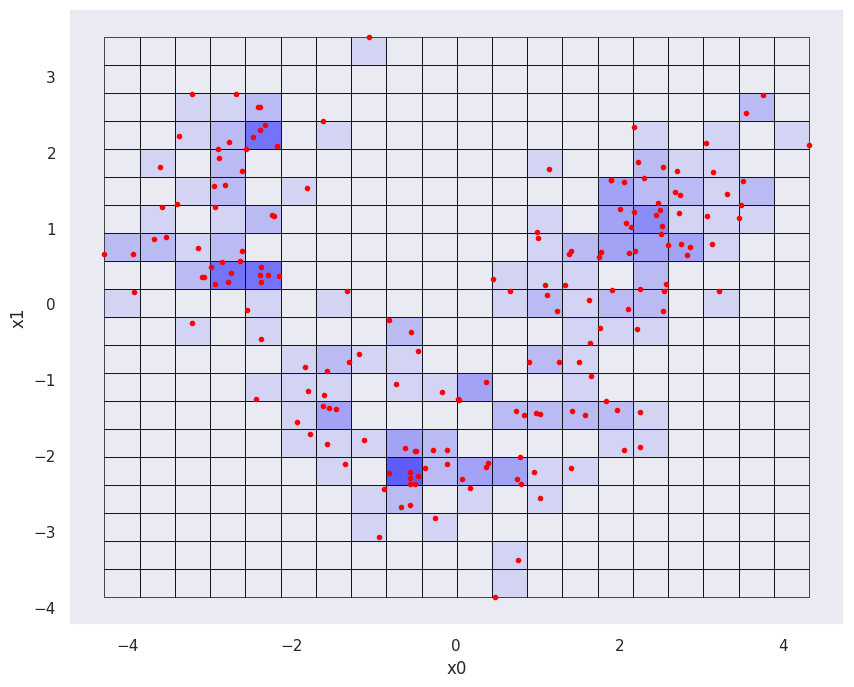

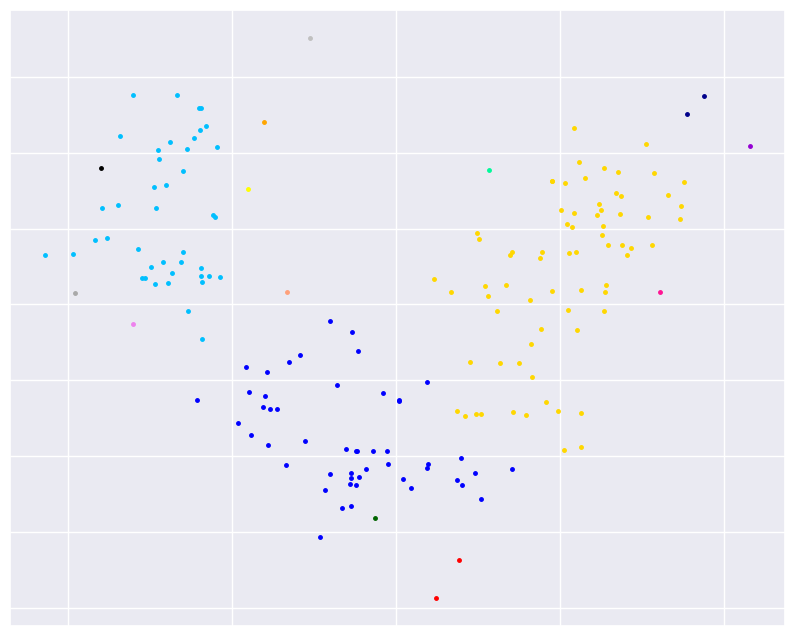

In [147]:
clique_visualizer.show_grid(cells, df_pca[:, :2]) 
clique_visualizer.show_clusters(df_pca[:, :2], clusters, noise) 